In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from partition import *
from constants import *

In [3]:
plt.style.use('../../scripts/atmospheres.mplstyle')


Bad key "xticks.labelsize" on line 11 in
../../scripts/atmospheres.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "yticks.labelsize" on line 12 in
../../scripts/atmospheres.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# what would you have wanted to know before?
# verification 

def phi(ionized_ion, T):
    """
    Calculates the phi function from Gray's eqs 1.20-1.21
    
    T - is the temperature in K
    ionized_ion - is the name of the lower ionization state
    """
    
    theta = 5040/T
    if ionized_ion=='H-':
        u1 = partition('H', T)
        u0 = partition(ionized_ion, T)
        xi = 0.754195 # eV
    else:
        u1 = partition(ionized_ion+'+', T)
        u0 = partition(ionized_ion, T) 
        ionization_file = pd.read_csv('../aux_files/nist_ioniz.txt', delim_whitespace=True, header=None)
        ionization_file.columns = ['Z', 'name', 'mass', 'ioniz_e']
        row = ionization_file[ionization_file['name']==ionized_ion]
        xi = row['ioniz_e'].values[0]
    
    return 1.2020e9*u1/u0*theta**(-5/2)*10**(-theta*xi)
    

In [52]:
def test(T):
    return phi('Fe', T)- 0.5

In [53]:
from scipy.optimize import fsolve

In [54]:
fsolve(test, 4000)

array([4239.50879641])

In [6]:
# completed

def kappa_Hminus_bf(Pe, T, wave):
    """
    Following equation 8.11-12 in Gray
    wave in angstroms
    T in kelvin
    Pe in cgs? dynes/cm^2
    """
    alpha_bf = 1.99654 - 1.18267e-5*wave + 2.64243e-6*wave**2 - 4.40524e-10*wave**3 + 3.23992e-14*wave**4 - 1.39568e-18*wave**5 + 2.78701e-23*wave**6
    theta = 5040/T
    if wave<1000 or wave>16200:
        return 0
    return 10**-18 * 4.158e-10 * alpha_bf * Pe * theta**(5/2) * 10**(0.754*theta)

In [7]:
kappa_Hminus_bf(100, 10000, 10000)

6.815805182317545e-25

In [8]:
# completed
def kappa_Hminus_ff(Pe, T, wave):
    """
    Following equation 8.13 in Gray
    """
    f0 = -2.2763-1.6850*np.log10(wave)+0.76661*(np.log10(wave))**2-0.053346*(np.log10(wave))**3
    f1 = 15.2827-9.2846*np.log10(wave)+1.99381*(np.log10(wave))**2-0.142631*(np.log10(wave))**3
    f2 = -197.789+190.266*np.log10(wave)-67.9775*(np.log10(wave))**2+10.6913*(np.log10(wave))**3-0.625151*(np.log10(wave))**4
    theta = 5040/T
    return 1e-26*Pe*10**(f0+f1*np.log10(theta)+f2*(np.log10(theta))**2) 

In [9]:
kappa_Hminus_ff(100, 10000, 10000)

3.5340582960430746e-25

In [12]:
def g_bf(n, T, wave):
    """
    equation 8.6 in gray
    """
    return 1-(0.3456)/(wave*1.0968e-3)**(1/3)*(wave*1.0968e-3/(n**2)-1/2)

In [13]:
def kappa_H_bf(Pe, T, wave):
    """
    Using equations 8.4, 8.5, 8.8
    """
    # find n0
    n0 = int(np.floor(np.sqrt(13.6*EV_TO_ERG/(PLANCK_ERG*SPEEDOFLIGHT/(wave*1e-8)))))+1

    theta = 5040/T
    n_array = np.array([n0, n0+1, n0+2])
    alpha0 = 1.0449e-26
    I = 13.6    # eV
    xi_array = I*(1-(1/((n_array)**2)))
    g_array = np.array([g_bf(i, T, wave) for i in n_array])
    summation = sum(g_array/(n_array**3)*10**(-theta*xi_array))
    xi3 = I*(1-1/((n0+3)**2)) 
    
    return alpha0*wave**3*(summation+(np.log10(np.e)/(2*theta*I))*(10**(-xi3*theta)-10**(-I*theta)))


In [14]:
kappa_H_bf(100, 10000, 10000)

1.1003375183879166e-22

In [15]:
# completed
def kappa_H_ff(Pe, T, wave):
    """
    Using equations 8.6, 8.10
    """
    R = 1.0968e-3  # inverse Angstroms
    theta = 5040/T
    g_ff = 1+0.3456/(wave*R)**(1/3)*(np.log10(np.e)/(theta*1.2398e4/wave)+0.5)
    alpha0 = 1.0449e-26
    I = 13.6 # in eV
    return alpha0*wave**3*g_ff*np.log10(np.e)/(2*theta*I)*10**(-theta*I)

In [16]:
kappa_H_ff(100, 10000, 10000)

5.48910954941534e-23

In [17]:
def kappa_e():
    return None

In [18]:
def kappa(Pe, T, wave):
    """
    equation 8.18
    """
    theta = 5040/T
    return ((kappa_H_bf(Pe, T, wave) + kappa_H_ff(Pe, T, wave) + kappa_Hminus_bf(Pe, T, wave))*(1-10**(-1.2398e4/wave*theta)) + kappa_Hminus_ff(Pe, T, wave))*1/(1+phi('H', T)/Pe)


In [19]:
kappa(100, 10000, 10000)

2.238630675011229e-23

In [20]:
wave_array = np.arange(2000.0, 20100.0, 100)

In [29]:
opacity_a = [kappa(10**1.08, 5143, i) for i in wave_array]
def stim_term(wave, T):
    return (1-10**(-1.2398e4/wave*(5040/T)))
def phi_term(Pe, T):
    return 1/(1+phi('H', T)/Pe)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


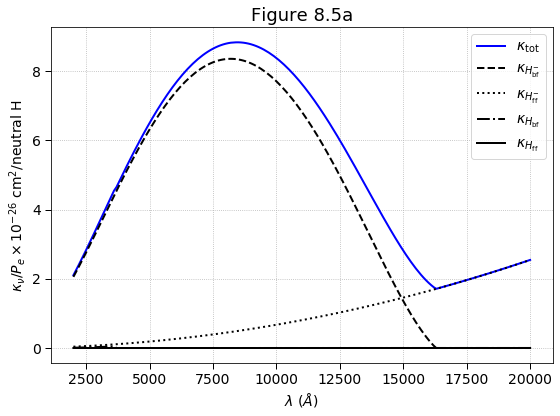

In [44]:
plt.figure(figsize=(8,6))
plt.plot(wave_array, np.array(opacity_a)/(10**1.08)*1e26, 'b-', label=r'$\kappa_{\rm tot}$')
plt.plot(wave_array, [kappa_Hminus_bf(10**1.08, 5143, i)*stim_term(i, 5143)*phi_term(10**1.08, 5143)/(10**1.08)*1e26 for i in wave_array], 'k--', label=r"$\kappa_{H^{-}_{\rm bf}}$")
plt.plot(wave_array, [kappa_Hminus_ff(10**1.08, 5143, i)*phi_term(10**1.08, 5143)/(10**1.08)*1e26 for i in wave_array], 'k:', label=r"$\kappa_{H^{-}_{\rm ff}}$")
plt.plot(wave_array, [kappa_H_bf(10**1.08, 5143, i)*stim_term(i, 5143)*phi_term(10**1.08, 5143)/(10**1.08)*1e26  for i in wave_array], 'k-.', label=r"$\kappa_{H_{\rm bf}}$")
plt.plot(wave_array, [kappa_H_ff(10**1.08, 5143, i)*stim_term(i, 5143)*phi_term(10**1.08, 5143)/(10**1.08)*1e26  for i in wave_array], 'k-', label=r"$\kappa_{H_{\rm ff}}$")
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu/P_e \times 10^{-26}$ cm$^2$/neutral H ')
plt.title('Figure 8.5a')
plt.legend()
plt.savefig('opacity_a.eps')

In [23]:
# b
opacity_b =[kappa(10**1.77, 6429, i) for i in wave_array]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


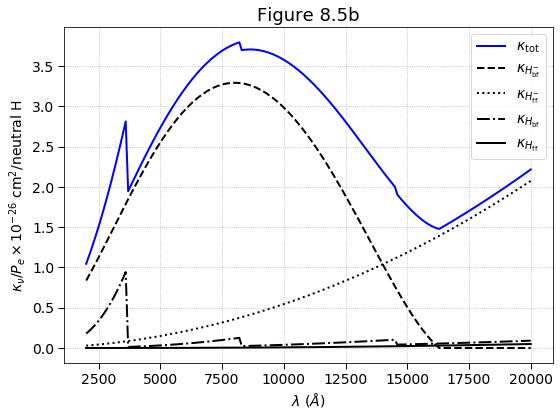

In [45]:
plt.figure(figsize=(8,6))
plt.plot(wave_array, np.array(opacity_b)/(10**1.77)*1e26, 'b-', label=r'$\kappa_{\rm tot}$')
plt.plot(wave_array, [kappa_Hminus_bf(10**1.77, 6429, i)*stim_term(i, 6429)*phi_term(10**1.77, 6429)/(10**1.77)*1e26 for i in wave_array], 'k--', label=r"$\kappa_{H^{-}_{\rm bf}}$")
plt.plot(wave_array, [kappa_Hminus_ff(10**1.77, 6429, i)*phi_term(10**1.77, 6429)/(10**1.77)*1e26 for i in wave_array], 'k:', label=r"$\kappa_{H^{-}_{\rm ff}}$")
plt.plot(wave_array, [kappa_H_bf(10**1.77, 6429, i)*stim_term(i, 6429)*phi_term(10**1.77, 6429)/(10**1.77)*1e26  for i in wave_array], 'k-.', label=r"$\kappa_{H_{\rm bf}}$")
plt.plot(wave_array, [kappa_H_ff(10**1.77, 6429, i)*stim_term(i, 6429)*phi_term(10**1.77, 6429)/(10**1.77)*1e26  for i in wave_array], 'k-', label=r"$\kappa_{H_{\rm ff}}$")
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu/P_e \times 10^{-26}$ cm$^2$/neutral H ')
plt.title('Figure 8.5b')
plt.legend()
plt.savefig('opacity_b.eps')

In [25]:
# c
opacity_c =[kappa(10**2.5, 7715, i) for i in wave_array]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


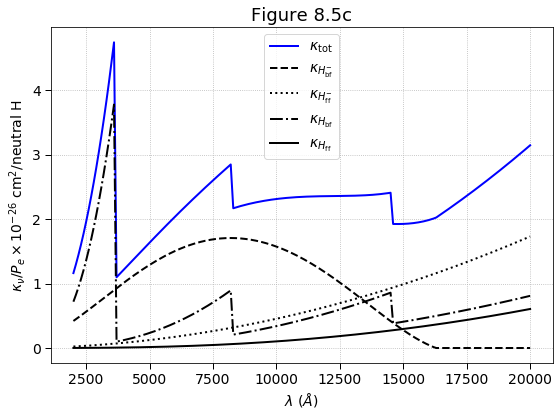

In [46]:
plt.figure(figsize=(8,6))
plt.plot(wave_array, np.array(opacity_c)/10**2.5*1e26, 'b-', label=r'$\kappa_{\rm tot}$')
plt.plot(wave_array, [kappa_Hminus_bf(10**2.5, 7715, i)*stim_term(i, 5143)*phi_term(10**2.5, 7715)/10**2.5*1e26 for i in wave_array], 'k--', label=r"$\kappa_{H^{-}_{\rm bf}}$")
plt.plot(wave_array, [kappa_Hminus_ff(10**2.5, 7715, i)*phi_term(10**2.5, 7715)/10**2.5*1e26 for i in wave_array], 'k:', label=r"$\kappa_{H^{-}_{\rm ff}}$")
plt.plot(wave_array, [kappa_H_bf(10**2.5, 7715, i)*stim_term(i, 7715)*phi_term(10**2.5, 7715)/10**2.5*1e26  for i in wave_array], 'k-.', label=r"$\kappa_{H_{\rm bf}}$")
plt.plot(wave_array, [kappa_H_ff(10**2.5, 7715, i)*stim_term(i, 7715)*phi_term(10**2.5, 7715)/10**2.5*1e26  for i in wave_array], 'k-', label=r"$\kappa_{H_{\rm ff}}$")
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu/P_e \times 10^{-26}$ cm$^2$/neutral H ')
plt.title('Figure 8.5c')
plt.legend()
plt.savefig('opacity_c.eps')

In [27]:
# d
opacity_d =[kappa(10**2.76, 11572, i) for i in wave_array]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


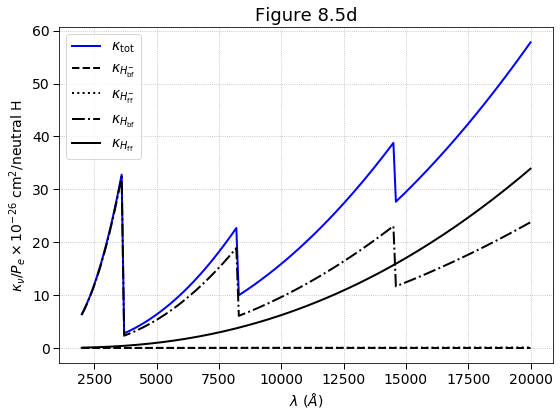

In [47]:
plt.figure(figsize=(8,6))
plt.plot(wave_array, np.array(opacity_d)/(10**2.76)*1e26, 'b-', label=r'$\kappa_{\rm tot}$')
plt.plot(wave_array, [kappa_Hminus_bf(10**2.76, 11572, i)*stim_term(i, 11572)*phi_term(10**2.76, 11572)/(10**2.76)*1e26 for i in wave_array], 'k--', label=r"$\kappa_{H^{-}_{\rm bf}}$")
plt.plot(wave_array, [kappa_Hminus_ff(10**2.76, 11572, i)*phi_term(10**2.76, 11572)/(10**2.76)*1e26 for i in wave_array], 'k:', label=r"$\kappa_{H^{-}_{\rm ff}}$")
plt.plot(wave_array, [kappa_H_bf(10**2.76, 11572, i)*stim_term(i, 11572)*phi_term(10**2.76, 11572)/(10**2.76)*1e26 for i in wave_array], 'k-.', label=r"$\kappa_{H_{\rm bf}}$")
plt.plot(wave_array, [kappa_H_ff(10**2.76, 11572, i)*stim_term(i, 11572)*phi_term(10**2.76, 11572)/(10**2.76)*1e26  for i in wave_array], 'k-', label=r"$\kappa_{H_{\rm ff}}$")
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu/P_e \times 10^{-26}$ cm$^2$/neutral H ')
plt.title('Figure 8.5d')
plt.legend()
plt.savefig('opacity_d.eps')